In [ ]:
# ==============================================================================
# NOTEBOOK: 03_deteccion_cambios.ipynb
# ==============================================================================
# Descripción: Detección y visualización de cambios urbanos multitemporales
#              utilizando índices espectrales calculados previamente.
#
# Este notebook implementa la Parte 3 del Laboratorio 2:
#   - Método 1: Diferencia simple de NDVI entre fechas
#   - Método 2: Clasificación de tipos de cambio (urbanización, vegetación, agua)
#   - Método 3: Análisis de anomalías temporales mediante Z-Score
#   - Validación con datos externos (Google Dynamic World)
#
# Área de estudio: Viña del Mar, Chile
# Período: 2019-2025
# Sistema de coordenadas: EPSG:32719 (UTM Zona 19S)
# ==============================================================================

# ==============================================================================
# CELDA 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN DE RUTAS
# ==============================================================================
# Propósito: Cargar todas las librerías necesarias y configurar la estructura
#            de directorios del proyecto.
# ==============================================================================

# --- LIBRERÍAS ESTÁNDAR DE PYTHON ---
import os # Para las operaciones del sistema operativo (variables de entorno, rutas)
import sys # para el acceso a parámetros del sistema (para agregar rutas al path de Python)

# --- LIBRERÍAS DE PROCESAMIENTO GEOESPACIAL ---
import rasterio # para la lectura y escritura de archivos raster (GeoTIFF)
import numpy as np # para operaciones numéricas con arrays multidimensionales
import geopandas as gpd # para la manipulación de datos vectoriales geoespaciales

# --- LIBRERÍAS DE VISUALIZACIÓN ---
import matplotlib.pyplot as plt # para la creación de gráficos y visualizaciones
import matplotlib.colors as mcolors # para la definición de mapas de colores personalizados

# --- UTILIDADES ---
import subprocess # para la ejecución de scripts externos desde Python
from pathlib import Path # para manipular rutas de archivos de forma multiplataforma
from rasterio.plot import show # para visualizar rasters rápidamente

# ==============================================================================
# CONFIGURACIÓN DE RUTAS DEL PROYECTO
# ==============================================================================
# Define la raíz del proyecto (directorio padre del notebook)
project_root = Path("..").resolve()
# Agrega el proyecto al path para poder importar módulos propios
sys.path.append(str(project_root))

# Directorio con los índices espectrales procesados
processed_dir = project_root / "data" / "processed"
# Directorio con archivos vectoriales (límites, manzanas, etc.)
vector_dir = project_root / "data" / "vector"
# Diccionario con directorios de salida organizados por tipo
output_dirs = {
    "figures": project_root / "outputs" / "figures",  # Gráficos estadísticos
    "maps":    project_root / "outputs" / "maps",     # Mapas georreferenciados
    "reports": project_root / "outputs" / "reports"   # Tablas y reportes CSV
}

# Carga el límite comunal para enmarcar las visualizaciones
gdf_limite = gpd.read_file(vector_dir / "limite_comuna.gpkg")

# Mensaje de confirmación de configuración exitosa
print(f"✔  Directorio de trabajo: {project_root}")

📂 Directorio de trabajo: C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano


In [ ]:
# ==============================================================================
# CELDA 2: EJECUCIÓN DEL SCRIPT DE DETECCIÓN DE CAMBIOS
# ==============================================================================
# Propósito: Ejecutar el script detect_changes.py que implementa los 3 métodos
#            de detección de cambios descritos en el enunciado del laboratorio.
#
# El script genera los siguientes archivos de salida:
#   - cambio_diferencia_indices_2019_2025.tif (Método 1: Diferencia Simple)
#   - cambio_urbano_2019_2025.tif (Método 2: Clasificación Urbana)
#   - anomalia_temporal_2025.tif (Método 3: Z-Score Histórico)
# ==============================================================================

# Define los años de inicio y fin del análisis multitemporal
YEAR_START = 2019  # Año base (antes de los cambios principales)
YEAR_END = 2025    # Año objetivo (estado actual)

print(f"➤ Ejecutando detección de cambios entre {YEAR_START} y {YEAR_END}...")

# Construye la ruta al script de detección de cambios
script_path = project_root / "scripts" / "detect_changes.py"

# Construye el comando a ejecutar como lista de argumentos
cmd = [
    sys.executable,      # Usa el mismo intérprete Python del kernel activo
    str(script_path),    # Ruta al script
    "--t1", str(YEAR_START),  # Argumento: año inicial
    "--t2", str(YEAR_END),    # Argumento: año final
    "--method", "all"         # Ejecutar todos los métodos (diff, urban, anomaly)
]

# Ejecuta el script como subproceso
# encoding="utf-8" y errors="replace" evitan errores con emojis en Windows
result = subprocess.run(cmd, capture_output=True, text=True, encoding="utf-8", errors="replace")

# Verifica el resultado de la ejecución
if result.returncode == 0:
    print("✔ Procesamiento Exitoso.")
    # Muestra la salida estándar del script (estadísticas y logs)
    print("\n--- SALIDA DEL SCRIPT ---")
    print(result.stdout)
else:
    # Si hubo error, muestra el mensaje de error
    print("✘ Error en el script:")
    print(result.stderr)

🚀 Ejecutando detección de cambios entre 2019 y 2025...
✅ Procesamiento Exitoso.

--- SALIDA DEL SCRIPT ---
🚀 Iniciando Detección de Cambios: 2019 -> 2025
--- Ejecutando Método 1: Diferencia Simple (Banda 1) ---
Ganancia (> 0.15): 53227 px (4.4%)
Pérdida (< -0.15): 101951 px (8.5%)
💾 Guardado: cambio_diferencia_indices_2019_2025.tif
--- Ejecutando Método 2: Clasificación Urbana ---
Clase Urbanización: 58309 px (~583.1 ha)
Clase Pérdida Veg: 31250 px (~312.5 ha)
Clase Ganancia Veg: 123460 px (~1234.6 ha)
Clase Nuevo Agua: 1511 px (~15.1 ha)
💾 Guardado: cambio_urbano_2019_2025.tif
--- Ejecutando Método 3: Anomalías Temporales (Target: 2025) ---
💾 Guardado: anomalia_temporal_2025.tif

🏁 Proceso finalizado. Resultados en C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano\data\processed



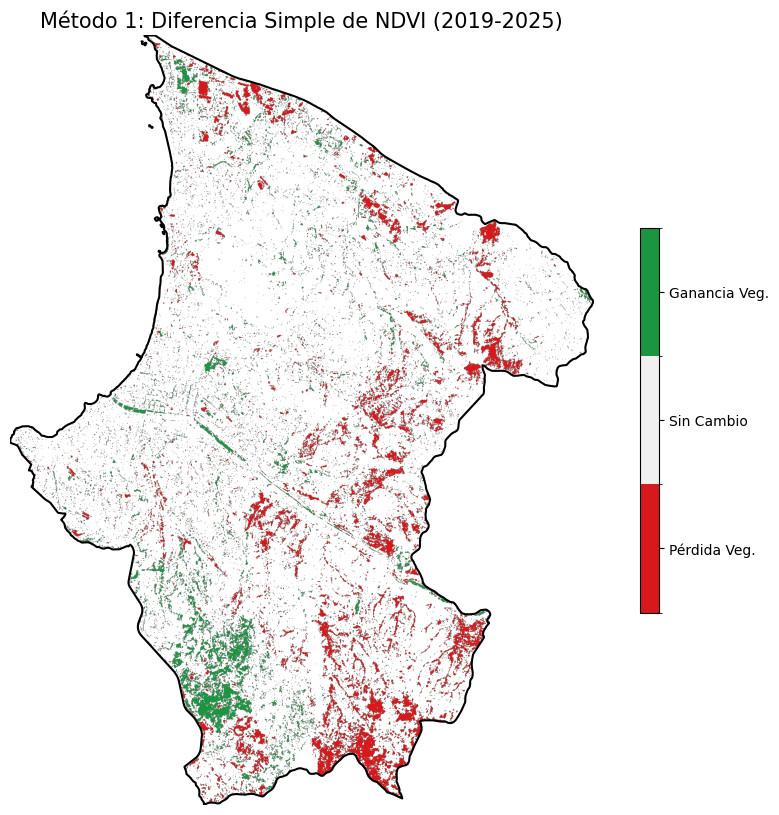

In [ ]:
# ==============================================================================
# CELDA 3: VISUALIZACIÓN DEL MÉTODO 1 - DIFERENCIA SIMPLE DE NDVI
# ==============================================================================
# Propósito: Generar un mapa que muestra los cambios de vegetación detectados
#            mediante la resta simple de NDVI (T2 - T1).
#
# Interpretación del mapa:
#   - ROJO (-1): Pérdida de vegetación (NDVI disminuyó > 0.15)
#   - GRIS (0): Sin cambio significativo
#   - VERDE (+1): Ganancia de vegetación (NDVI aumentó > 0.15)
#
# Salida: outputs/maps/03_mapa_diferencia_simple.png
# ==============================================================================

# Importa la función mask para recortar rasters con geometrías vectoriales
from rasterio.mask import mask
# Importa función para crear transformaciones geoespaciales
from rasterio.transform import from_origin

# Construye la ruta al archivo de diferencia generado por el script
file_diff = processed_dir / f"cambio_diferencia_indices_{YEAR_START}_{YEAR_END}.tif"

# Verifica que el archivo exista antes de procesarlo
if file_diff.exists():
    # Abre el archivo raster en modo lectura
    with rasterio.open(file_diff) as src:
        # --- PREPARACIÓN DEL VECTOR DE RECORTE ---
        # Reproyecta el límite comunal al CRS del raster si es necesario
        if gdf_limite.crs != src.crs:
            gdf_recorte = gdf_limite.to_crs(src.crs)
        else:
            gdf_recorte = gdf_limite

        # --- LECTURA CON RECORTE ESPACIAL ---
        # crop=True: recorta al bounding box de la geometría (zoom a la comuna)
        # nodata=-99: valor para identificar píxeles fuera del límite
        out_image, out_transform = mask(src, gdf_recorte.geometry, crop=True, nodata=-99)
        
        # Extrae la primera banda y convierte a float para usar NaN
        data = out_image[0].astype(float)
        # Convierte el valor nodata a NaN para transparencia en visualización
        data[data == -99] = np.nan 
        
        # --- CÁLCULO DE EXTENSIÓN PARA EL GRÁFICO ---
        # Obtiene dimensiones del array recortado
        height, width = data.shape
        # Calcula las coordenadas geográficas del recorte (left, right, bottom, top)
        extent = [
            out_transform[2],                           # X mínimo (izquierda)
            out_transform[2] + out_transform[0] * width,  # X máximo (derecha)
            out_transform[5] + out_transform[4] * height, # Y mínimo (abajo)
            out_transform[5]                            # Y máximo (arriba)
        ]
        
        # --- CONFIGURACIÓN DEL MAPA DE COLORES CATEGÓRICO ---
        # Define colores: rojo para pérdida, gris para sin cambio, verde para ganancia
        cmap = mcolors.ListedColormap(['#d7191c', '#f0f0f0', '#1a9641'])
        # Define los límites entre categorías (-1.5, -0.5, 0.5, 1.5)
        bounds = [-1.5, -0.5, 0.5, 1.5]
        # Crea normalizador que asigna colores según los límites definidos
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # --- CREACIÓN DE LA FIGURA ---
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Plotea el raster con el colormap categórico
        im = ax.imshow(data, cmap=cmap, norm=norm, extent=extent)
        
        # Agrega el borde del límite comunal (sin relleno)
        gdf_recorte.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
        
        # --- CONFIGURACIÓN DE LA LEYENDA ---
        # Crea barra de color con etiquetas personalizadas
        cbar = plt.colorbar(im, ticks=[-1, 0, 1], shrink=0.5)
        cbar.ax.set_yticklabels(['Pérdida Veg.', 'Sin Cambio', 'Ganancia Veg.'])
        
        # Configura título del mapa
        ax.set_title(f"Método 1: Diferencia Simple de NDVI ({YEAR_START}-{YEAR_END})", fontsize=15)
        # Oculta los ejes de coordenadas para una visualización más limpia
        ax.axis('off')
        
        # --- GUARDADO Y VISUALIZACIÓN ---
        plt.savefig(output_dirs["maps"] / "03_mapa_diferencia_simple.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("✘ Archivo no encontrado.")

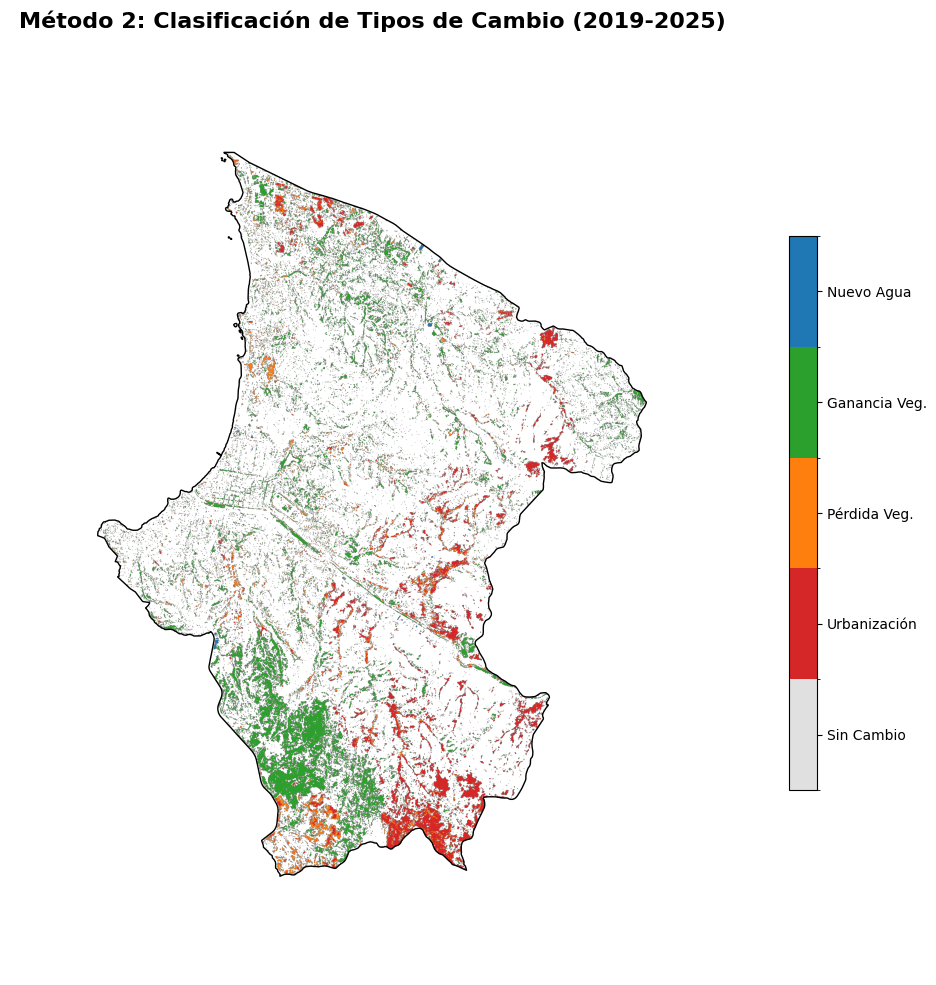

In [ ]:
# ==============================================================================
# CELDA 4: VISUALIZACIÓN DEL MÉTODO 2 - CLASIFICACIÓN DE CAMBIO URBANO
# ==============================================================================
# Propósito: Generar un mapa que muestra los diferentes tipos de cambio
#            detectados combinando NDVI, NDBI y NDWI.
#
# Clases de cambio:
#   - GRIS (0): Sin cambio significativo
#   - ROJO (1): Urbanización (vegetación → área construida)
#   - NARANJA (2): Pérdida de vegetación (no urbana, ej: incendios)
#   - VERDE (3): Ganancia de vegetación (recuperación)
#   - AZUL (4): Nuevo cuerpo de agua
#
# Salida: outputs/maps/03_mapa_cambio_urbano_clasificado.png
# ==============================================================================

# Construye la ruta al archivo de clasificación urbana
file_urban = processed_dir / f"cambio_urbano_{YEAR_START}_{YEAR_END}.tif"

# Verifica que el archivo exista
if file_urban.exists():
    # Abre el archivo raster
    with rasterio.open(file_urban) as src:
        # --- PREPARACIÓN DEL RECORTE VECTORIAL ---
        # Reproyecta si el CRS no coincide
        if gdf_limite.crs != src.crs:
            gdf_recorte = gdf_limite.to_crs(src.crs)
        else:
            gdf_recorte = gdf_limite

        # --- LECTURA CON MÁSCARA ---
        # crop=False mantiene las dimensiones originales
        # nodata=-99 marca los píxeles fuera del límite
        out_image, out_transform = mask(src, gdf_recorte.geometry, crop=False, nodata=-99)
        
        # Convierte a float para usar NaN como valor de fondo transparente
        data = out_image[0].astype(float)
        data[data == -99] = np.nan
        
        # --- CONFIGURACIÓN DE COLORES CATEGÓRICOS ---
        # Define una paleta de 5 colores para las 5 clases
        colors = ['#e0e0e0', '#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
        # Etiquetas descriptivas para cada clase
        labels = ['Sin Cambio', 'Urbanización', 'Pérdida Veg.', 'Ganancia Veg.', 'Nuevo Agua']
        
        # Crea el mapa de colores discreto
        cmap = mcolors.ListedColormap(colors)
        # Define límites entre clases (centrados en 0, 1, 2, 3, 4)
        bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # --- CREACIÓN DEL MAPA ---
        fig, ax = plt.subplots(figsize=(14, 12))
        
        # Plotea el raster con el mapa de colores categórico
        # plotting_extent calcula automáticamente la extensión del raster
        im = ax.imshow(data, cmap=cmap, norm=norm, extent=rasterio.plot.plotting_extent(src))
        # Superpone el borde del límite comunal
        gdf_recorte.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
        
        # --- LEYENDA CATEGÓRICA ---
        # Crea barra de color con ticks en el centro de cada clase
        cbar = plt.colorbar(im, ticks=[0, 1, 2, 3, 4], shrink=0.6)
        cbar.ax.set_yticklabels(labels)
        
        # Configura título con formato destacado
        ax.set_title(f"Método 2: Clasificación de Tipos de Cambio ({YEAR_START}-{YEAR_END})", fontsize=16, fontweight='bold')
        ax.set_axis_off()
        
        # --- GUARDADO Y VISUALIZACIÓN ---
        plt.savefig(output_dirs["maps"] / "03_mapa_cambio_urbano_clasificado.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("✘ Archivo no encontrado.")

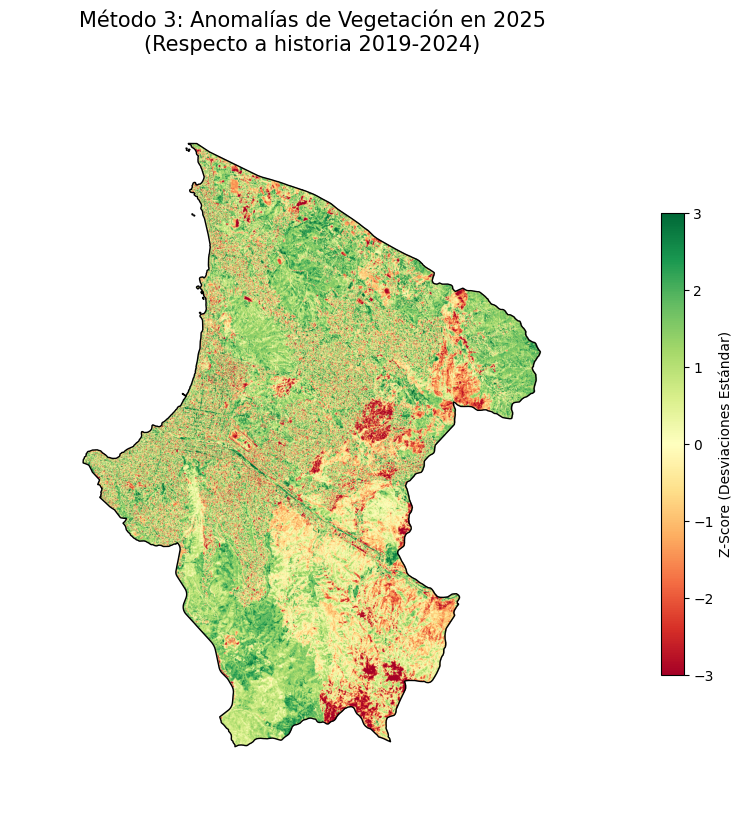

In [ ]:
# ==============================================================================
# CELDA 5: VISUALIZACIÓN DEL MÉTODO 3 - ANOMALÍAS TEMPORALES (Z-SCORE)
# ==============================================================================
# Propósito: Generar un mapa de calor que muestra las anomalías de vegetación
#            del año objetivo respecto al promedio histórico.
#
# El Z-Score indica cuántas desviaciones estándar se desvía el valor actual
# de la media histórica:
#   - ROJO (Z < -2): Anomalía negativa (menos vegetación de lo normal)
#   - AMARILLO (Z ≈ 0): Comportamiento normal
#   - VERDE (Z > 2): Anomalía positiva (más vegetación de lo normal)
#
# Este método es especialmente útil para:
#   - Detectar cambios que se desvían del patrón estacional típico
#   - Identificar áreas de estrés hídrico o degradación gradual
#   - Filtrar variaciones climáticas normales
#
# Salida: outputs/maps/03_mapa_anomalias_zscore.png
# ==============================================================================

# Construye la ruta al archivo de anomalías del año objetivo
file_anom = processed_dir / f"anomalia_temporal_{YEAR_END}.tif"

# Verifica que el archivo exista
if file_anom.exists():
    # Abre el archivo raster
    with rasterio.open(file_anom) as src:
        # Lee la primera banda (Z-Score de NDVI)
        data = src.read(1)
        
        # --- CORRECCIÓN DEL FONDO ---
        # El script guardó el fondo como 0, lo convertimos a NaN para transparencia
        data[data == 0] = np.nan
        
        # --- FILTROS VISUALES ---
        # Trunca valores extremos para mejorar el contraste visual
        # Valores fuera de [-3, 3] son raros (solo 0.3% en distribución normal)
        data[data < -3] = -3
        data[data > 3] = 3
        
        # --- CREACIÓN DEL MAPA DE CALOR ---
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Usa colormap divergente RdYlGn (Rojo-Amarillo-Verde)
        # Centrado en 0 (amarillo = normal)
        im = ax.imshow(data, cmap='RdYlGn', vmin=-3, vmax=3, extent=rasterio.plot.plotting_extent(src))
        
        # Superpone el límite comunal reproyectado al CRS del raster
        gdf_limite.to_crs(src.crs).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
        
        # --- BARRA DE COLOR CON ETIQUETA ---
        cbar = plt.colorbar(im, shrink=0.6, label="Z-Score (Desviaciones Estándar)")
        
        # Configura título con contexto histórico
        ax.set_title(f"Método 3: Anomalías de Vegetación en {YEAR_END}\n(Respecto a historia 2019-{YEAR_END-1})", fontsize=15)
        ax.set_axis_off()
        
        # --- GUARDADO Y VISUALIZACIÓN ---
        plt.savefig(output_dirs["maps"] / "03_mapa_anomalias_zscore.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("✘ Archivo no encontrado.")

⬇️ Verificando/Descargando datos de validación (Dynamic World)...
📍 Los datos de validación se guardarán en: C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano\data\validation
✅ GEE inicializado.
🚀 Descargando datos de validación (Dynamic World)...
✅ [YA EXISTE] reference_lulc_2019.tif
✅ [YA EXISTE] reference_lulc_2025.tif

🏁 Datos de validación listos.

✅ Datos de validación listos.

📊 Generando Matriz de Confusión...


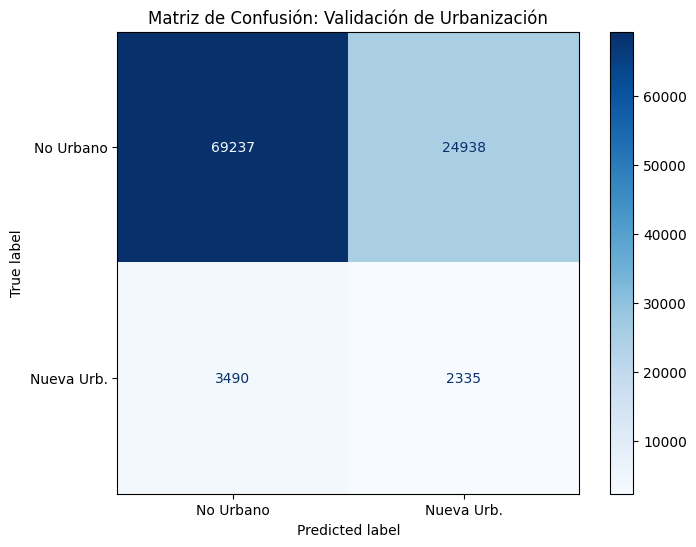

💾 Matriz guardada en CSV: C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano\outputs\reports\03_matriz_confusion.csv
------------------------------
📊 Precisión (Accuracy de Urbanización): 0.09
🎯 Recall (Sensibilidad): 0.40
⭐ F1-Score: 0.14
------------------------------


In [ ]:
# ==============================================================================
# CELDA 6: VALIDACIÓN CON DATOS EXTERNOS (GOOGLE DYNAMIC WORLD)
# ==============================================================================
# Propósito: Validar los resultados de detección de cambios comparándolos
#            con datos de referencia (Ground Truth) de Google Dynamic World.
#
# Este paso es crucial para evaluar la precisión del Método 2 (Clasificación
# Urbana) y corresponde al criterio 7.0 del laboratorio.
#
# Proceso:
#   1. Descarga automática de clasificaciones Dynamic World (2019, 2025)
#   2. Cálculo de "cambio urbano real" según Dynamic World
#   3. Comparación con nuestra predicción (Método 2)
#   4. Generación de matriz de confusión y métricas de precisión
#
# Métricas calculadas:
#   - Precisión: TP / (TP + FP) - ¿Cuántos de los detectados son reales?
#   - Recall: TP / (TP + FN) - ¿Cuántos de los reales fueron detectados?
#   - F1-Score: Media armónica de precisión y recall
#
# Salidas:
#   - outputs/figures/03_matriz_confusion.png
#   - outputs/reports/03_matriz_confusion.csv
# ==============================================================================

# Importa métricas de evaluación de scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Importa pandas para manejo de datos tabulares
import pandas as pd

# ==============================================================================
# PASO 1: DESCARGA AUTOMÁTICA DE DATOS DE VALIDACIÓN
# ==============================================================================
print("➤ Verificando/Descargando datos de validación (Dynamic World)...")

# Ruta al script de descarga de datos de validación
script_val = project_root / "scripts" / "download_validation.py"

# Construye el comando usando el Python del kernel activo
cmd_val = [sys.executable, str(script_val)]
# Ejecuta con encoding UTF-8 para manejar emojis en Windows
result_val = subprocess.run(cmd_val, capture_output=True, text=True, encoding="utf-8", errors="replace")

# Verifica el resultado de la descarga
if result_val.returncode != 0:
    print("✘ Error descargando validación:")
    print(result_val.stderr)
else:
    print(result_val.stdout)
    print("✔ Datos de validación listos.")

# ==============================================================================
# PASO 2: CÁLCULO DE MATRIZ DE CONFUSIÓN
# ==============================================================================
print("\n✔ Generando Matriz de Confusión...")

# Define rutas a los archivos de referencia de Dynamic World
ref_2019_path = project_root / "data" / "validation" / "reference_lulc_2019.tif"
ref_2025_path = project_root / "data" / "validation" / "reference_lulc_2025.tif"

# Verifica que ambos archivos de referencia existan
if ref_2019_path.exists() and ref_2025_path.exists():
    # Abre ambos archivos de referencia simultáneamente
    with rasterio.open(ref_2019_path) as src1, rasterio.open(ref_2025_path) as src2:
        # Recorta los rasters de referencia al límite comunal
        ref_2019, _ = mask(src1, gdf_limite.geometry, crop=True)
        ref_2025, _ = mask(src2, gdf_limite.geometry, crop=True)
        
        # Aplana los arrays 3D a 1D para comparación píxel a píxel
        y_2019 = ref_2019[0].flatten()
        y_2025 = ref_2025[0].flatten()
        
        # --- DEFINICIÓN DEL GROUND TRUTH (VERDAD) ---
        # Cambio Urbano Real: NO era Urbano (clase 6) en 2019 Y SÍ es Urbano en 2025
        # Nota: En Dynamic World, clase 6 = "Built" (Construido/Urbano)
        cambio_real = np.zeros_like(y_2019, dtype=int)
        mask_urbanizacion_real = (y_2019 != 6) & (y_2025 == 6)
        cambio_real[mask_urbanizacion_real] = 1  # 1 = Cambio urbano real detectado
        
    # --- CARGA DE LA PREDICCIÓN (MÉTODO 2) ---
    if file_urban.exists():
        with rasterio.open(file_urban) as src_pred:
            # Recorta la predicción al mismo extent
            pred_img, _ = mask(src_pred, gdf_limite.geometry, crop=True, nodata=-99)
            y_pred_map = pred_img[0].flatten()
            
            # Simplifica a clasificación binaria:
            # 1 = Urbanización detectada (Clase 1 del Método 2)
            # 0 = Otro tipo de cambio o sin cambio
            y_pred = np.zeros_like(y_pred_map, dtype=int)
            y_pred[y_pred_map == 1] = 1 
            
        # --- FILTRADO Y MUESTREO ALEATORIO ---
        # Filtra píxeles válidos (ignora bordes y nubes)
        valid_pixels = (y_2019 != 0) & (y_pred_map != -99)
        
        # Obtiene índices de píxeles válidos
        indices = np.where(valid_pixels)[0]
        # Muestreo aleatorio si hay muchos píxeles (evita saturar memoria)
        if len(indices) > 100000:
            indices = np.random.choice(indices, 100000, replace=False)
        
        # Extrae muestras para comparación
        y_true_sample = cambio_real[indices]
        y_pred_sample = y_pred[indices]
        
        # --- CÁLCULO Y VISUALIZACIÓN DE MATRIZ ---
        cm = confusion_matrix(y_true_sample, y_pred_sample)
        
        # Crea figura para la matriz de confusión
        fig, ax = plt.subplots(figsize=(8, 6))
        # Usa ConfusionMatrixDisplay para visualización estándar
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Urbano", "Nueva Urb."])
        disp.plot(ax=ax, cmap="Blues", values_format="d")
        ax.set_title("Matriz de Confusión: Validación de Urbanización")
        
        # Guarda la figura
        plt.savefig(output_dirs["figures"] / "03_matriz_confusion.png", bbox_inches='tight')
        plt.show()
        
        # --- EXPORTACIÓN A CSV ---
        # Crea DataFrame con la matriz de confusión
        df_cm = pd.DataFrame(cm, 
                             index=["Real: No Urbano", "Real: Nueva Urb."], 
                             columns=["Pred: No Urbano", "Pred: Nueva Urb."])
        
        # Guarda en CSV
        csv_path = output_dirs["reports"] / "03_matriz_confusion.csv"
        df_cm.to_csv(csv_path)
        print(f"✔ Matriz guardada en CSV: {csv_path}")

        # --- CÁLCULO DE MÉTRICAS DE EVALUACIÓN ---
        # Extrae los 4 componentes de la matriz de confusión
        tn, fp, fn, tp = cm.ravel()
        # Precisión: ¿Qué proporción de detecciones positivas son correctas?
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        # Recall: ¿Qué proporción de casos reales fueron detectados?
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        # F1-Score: Media armónica de precisión y recall
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Imprime resumen de métricas
        print("-" * 30)
        print(f"➤ Precisión (Accuracy de Urbanización): {precision:.2f}")
        print(f"➤ Recall (Sensibilidad): {recall:.2f}")
        print(f"➤ F1-Score: {f1:.2f}")
        print("-" * 30)
    else:
        print("✘ No se encontró el archivo de predicción (Método 2). Revisa las celdas anteriores.")

else:
    print("✘ Error crítico: No se pudieron cargar los datos de validación.")

🗺️ Generando mapa comparativo...
🔍 Píxeles detectados en Ground Truth: 57424.0
🔍 Píxeles detectados en Predicción: 58309.0


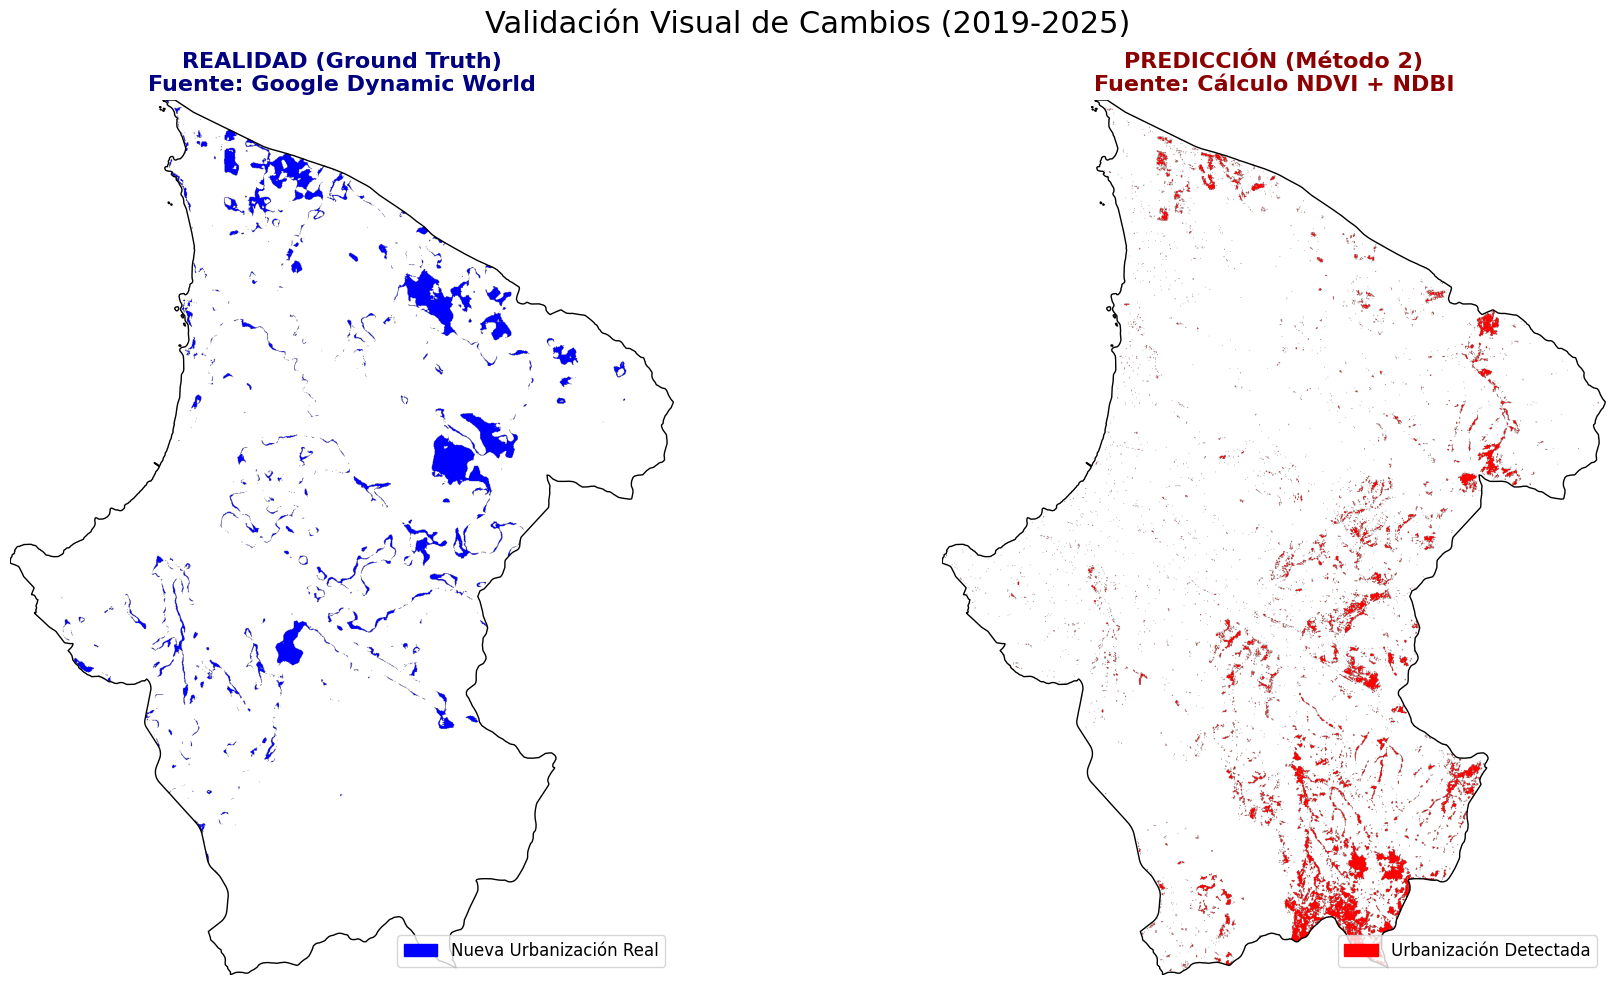

💾 Mapa comparativo guardado en: C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano\outputs\maps\03_validacion_visual_mapa.png


In [ ]:
# ==============================================================================
# CELDA 7: MAPA VISUAL DE VALIDACIÓN - COMPARACIÓN LADO A LADO
# ==============================================================================
# Propósito: Generar un mapa comparativo que muestra visualmente la diferencia
#            entre el Ground Truth (Dynamic World) y nuestra predicción (Método 2).
#
# Este mapa es fundamental para:
#   - Comunicar visualmente la calidad de la detección
#   - Identificar patrones espaciales de errores
#   - Validar cualitativamente los resultados
#
# Estructura del mapa:
#   - Panel izquierdo: "Realidad" - Cambios reales según Google Dynamic World
#   - Panel derecho: "Predicción" - Cambios detectados por nuestro Método 2
#
# Salida: outputs/maps/03_validacion_visual_mapa.png
# ==============================================================================

# Importa patches para crear elementos de leyenda personalizados
import matplotlib.patches as mpatches
# Importa mask (por si no se cargó en celda anterior)
from rasterio.mask import mask

print("➤ Generando mapa comparativo...")

def get_extent_from_transform(transform, width, height):
    """
    Calcula la extensión geográfica correcta a partir de una transformación afín.
    
    Descripción:
        Convierte los parámetros de una transformación raster (affine transform)
        a coordenadas de extensión para usar en matplotlib imshow.
    
    Entradas:
        transform (Affine): Transformación afín del raster (6 parámetros)
        width (int): Ancho del raster en píxeles
        height (int): Alto del raster en píxeles
    
    Salidas:
        list: [minx, maxx, miny, maxy] - Coordenadas de la extensión
    """
    # Calcula coordenada X mínima (esquina superior izquierda)
    minx = transform[2]
    # Calcula coordenada X máxima (ancho * resolución + origen)
    maxx = transform[2] + (width * transform[0])
    # Calcula coordenada Y máxima (esquina superior izquierda)
    maxy = transform[5]
    # Calcula coordenada Y mínima (alto * resolución negativa + origen)
    miny = transform[5] + (height * transform[4])
    return [minx, maxx, miny, maxy]

# Verifica que existan los archivos necesarios
if 'ref_2019_path' in locals() and ref_2019_path.exists() and file_urban.exists():
    
    # ==========================================================================
    # PREPARACIÓN DE DATOS: GROUND TRUTH (REALIDAD)
    # ==========================================================================
    with rasterio.open(ref_2019_path) as src1, rasterio.open(ref_2025_path) as src2:
        # Reproyecta el límite comunal si es necesario
        if gdf_limite.crs != src1.crs:
            gdf_recorte = gdf_limite.to_crs(src1.crs)
        else:
            gdf_recorte = gdf_limite

        # Lee los rasters recortados al límite comunal
        # crop=True para hacer zoom solo a la comuna
        ref_2019, out_transform = mask(src1, gdf_recorte.geometry, crop=True, nodata=0)
        ref_2025, _ = mask(src2, gdf_recorte.geometry, crop=True, nodata=0)
        
        # Calcula la extensión geográfica del recorte
        h, w = ref_2019[0].shape
        extent_gt = get_extent_from_transform(out_transform, w, h)
        
        # Calcula el mapa de cambio real (Ground Truth)
        # Cambio real = No era urbano en 2019 Y es urbano en 2025
        cambio_real_map = np.zeros_like(ref_2019[0], dtype=float)
        mask_real = (ref_2019[0] != 6) & (ref_2025[0] == 6) & (ref_2019[0] != 0)
        cambio_real_map[mask_real] = 1
        # Convierte 0 a NaN para transparencia
        cambio_real_map[cambio_real_map == 0] = np.nan 

    # ==========================================================================
    # PREPARACIÓN DE DATOS: PREDICCIÓN (MÉTODO 2)
    # ==========================================================================
    with rasterio.open(file_urban) as src_pred:
        # Lee el raster de predicción recortado
        pred_img, out_transform_pred = mask(src_pred, gdf_recorte.geometry, crop=True, nodata=-99)
        pred_data = pred_img[0].astype(float)
        
        # Calcula extensión del recorte
        h_p, w_p = pred_data.shape
        extent_pred = get_extent_from_transform(out_transform_pred, w_p, h_p)
        
        # Extrae solo la clase de urbanización (clase 1)
        pred_urban = np.zeros_like(pred_data)
        pred_urban[pred_data == 1] = 1
        # Convierte 0 a NaN para transparencia
        pred_urban[pred_urban == 0] = np.nan 

    # --- DIAGNÓSTICO RÁPIDO ---
    # Muestra conteo de píxeles para verificar que hay datos
    print(f"🔍 Píxeles detectados en Ground Truth: {np.nansum(cambio_real_map)}")
    print(f"🔍 Píxeles detectados en Predicción: {np.nansum(pred_urban)}")

    # ==========================================================================
    # CREACIÓN DEL MAPA COMPARATIVO
    # ==========================================================================
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # Define colormaps de un solo color para cada panel
    cmap_google = mcolors.ListedColormap(['blue'])  # Azul para Ground Truth
    cmap_pred   = mcolors.ListedColormap(['red'])   # Rojo para Predicción

    # --- PANEL IZQUIERDO: GROUND TRUTH (REALIDAD) ---
    # Capa 1: El raster de datos (zorder=1 = capa inferior)
    ax[0].imshow(cambio_real_map, cmap=cmap_google, extent=extent_gt, zorder=1)
    # Capa 2: El borde vectorial (zorder=2 = encima, facecolor='none' = sin relleno)
    gdf_recorte.plot(ax=ax[0], facecolor='none', edgecolor='black', linewidth=1, zorder=2)
    # Título con formato destacado
    ax[0].set_title("REALIDAD (Ground Truth)\nFuente: Google Dynamic World", fontsize=16, fontweight='bold', color='navy')
    ax[0].axis('off')
    # Leyenda personalizada
    legend_google = [mpatches.Patch(color='blue', label='Nueva Urbanización Real')]
    ax[0].legend(handles=legend_google, loc='lower right', fontsize=12)

    # --- PANEL DERECHO: PREDICCIÓN (MÉTODO 2) ---
    # Capa 1: El raster de predicción
    ax[1].imshow(pred_urban, cmap=cmap_pred, extent=extent_pred, zorder=1)
    # Capa 2: El borde vectorial (facecolor='none' es clave para no tapar datos)
    gdf_recorte.plot(ax=ax[1], facecolor='none', edgecolor='black', linewidth=1, zorder=2)
    # Título con formato destacado
    ax[1].set_title("PREDICCIÓN (Método 2)\nFuente: Cálculo NDVI + NDBI", fontsize=16, fontweight='bold', color='darkred')
    ax[1].axis('off')
    # Leyenda personalizada
    legend_pred = [mpatches.Patch(color='red', label='Urbanización Detectada')]
    ax[1].legend(handles=legend_pred, loc='lower right', fontsize=12)
    
    # --- TÍTULO GENERAL Y GUARDADO ---
    plt.suptitle(f"Validación Visual de Cambios ({YEAR_START}-{YEAR_END})", fontsize=22, y=0.98)
    plt.tight_layout()
    
    # Guarda el mapa
    save_path = output_dirs["maps"] / "03_validacion_visual_mapa.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✔ Mapa comparativo guardado en: {save_path}")

else:
    print("✘ Faltan archivos para generar el mapa.")

In [ ]:
# ==============================================================================
# CELDA 8: ESPACIO PARA ANÁLISIS ADICIONALES
# ==============================================================================
# Propósito: Celda vacía disponible para análisis complementarios.
#
# Sugerencias de análisis adicionales para mejorar la nota (criterio 7.0):
#   - Análisis de fragmentación del paisaje urbano
#   - Correlación con datos censales (cambio vs. crecimiento poblacional)
#   - Predicción de cambio futuro con modelo simple
#   - Animación temporal (GIF de cambios anuales)
#   - Análisis de series temporales con suavizado Savitzky-Golay
#
# ==============================================================================
